In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from pprint import pprint
from rouge import Rouge

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional, Concatenate
from keras.optimizers import Adam, Nadam
from keras.losses import sparse_categorical_crossentropy, KLDivergence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
df = pd.read_csv('../data/wikihowAll_cleaned.csv', delimiter=',', nrows=5000)

In [4]:
df.head()

,headline,text
0,keep related supplies in the same area make an...,photographer keep necessary lens cord battery ...
1,create a sketch in the neopoprealist manner of...,see image draw develops stepbystep however imp...
2,get a bachelors degree enroll in a studiobased...,possible become vfx artist without college deg...
3,start with some experience or interest in art ...,best art investor research piece art buy someo...
4,keep your reference materials sketches article...,start planning project work shall likely gathe...


In [5]:
df['headline'] = df['headline'].apply(lambda x : 'SOS '+ x + ' EOS')

In [6]:
df.head()

,headline,text
0,SOS keep related supplies in the same area mak...,photographer keep necessary lens cord battery ...
1,SOS create a sketch in the neopoprealist manne...,see image draw develops stepbystep however imp...
2,SOS get a bachelors degree enroll in a studiob...,possible become vfx artist without college deg...
3,SOS start with some experience or interest in ...,best art investor research piece art buy someo...
4,SOS keep your reference materials sketches art...,start planning project work shall likely gathe...


Розділимо датасет на тренувальний, тестувальний і валідаційний

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(df, test_size=0.10, random_state=42, shuffle=True)

In [9]:
train, val = train_test_split(train, test_size=0.11, random_state=42, shuffle=True)

In [10]:
train.shape

(4005, 2)

In [11]:
test.shape

(500, 2)

In [12]:
val.shape

(495, 2)

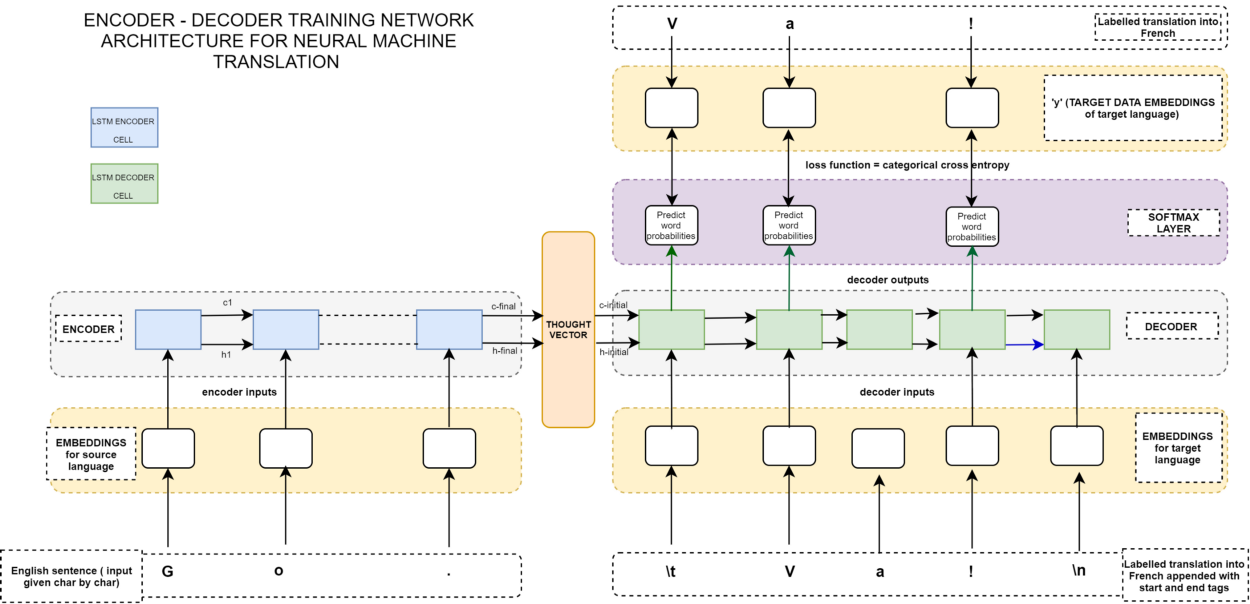

https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

In [13]:
max_len_text = 150 
max_len_summary = 50

Keras padding https://keras.io/guides/understanding_masking_and_padding/

In [14]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(train['text'])
x_vocab = len(x_tokenizer.word_index) + 1

x_train = x_tokenizer.texts_to_sequences(train['text'])
x_val = x_tokenizer.texts_to_sequences(val['text'])

x_train = pad_sequences(x_train, maxlen=max_len_text, padding="post")
x_val = pad_sequences(x_val, maxlen=max_len_text, padding="post")

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(train['headline'])
y_vocab = len(y_tokenizer.word_index) + 1

y_train= y_tokenizer.texts_to_sequences(train['headline'])
y_val = y_tokenizer.texts_to_sequences(val['headline'])

y_train = pad_sequences(y_train, maxlen=max_len_summary, padding="post")
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding="post")

Keras building seq2seq https://keras.io/examples/nlp/lstm_seq2seq/

In [16]:
latent_dim = 400 
embedding_dim = 200

# Encoder 
encoder_inputs = Input(shape=(max_len_text,), name="encoder_in") 
enc_emb_layer = Embedding(x_vocab, embedding_dim, name="encoder_emb")
enc_emb = enc_emb_layer(encoder_inputs) 

# LSTM
encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True, name="encoder_first_lstm") 
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) 

# Decoder 
decoder_inputs = Input(shape=(None,), name="decoder_in") 
dec_emb_layer = Embedding(y_vocab, embedding_dim, name="decoder_emb") 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_first_lstm") 
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Dense layer
decoder_dense = Dense(y_vocab, activation='softmax', name="decoder_dense") 
decoder_outputs = decoder_dense(decoder_outputs) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_in (InputLayer)         (None, 150)          0                                            
__________________________________________________________________________________________________
decoder_in (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
encoder_emb (Embedding)         (None, 150, 200)     7258000     encoder_in[0][0]                 
__________________________________________________________________________________________________
decoder_emb (Embedding)         (None, None, 200)    2359000     decoder_in[0][0]                 
____________________________________________________________________________________________

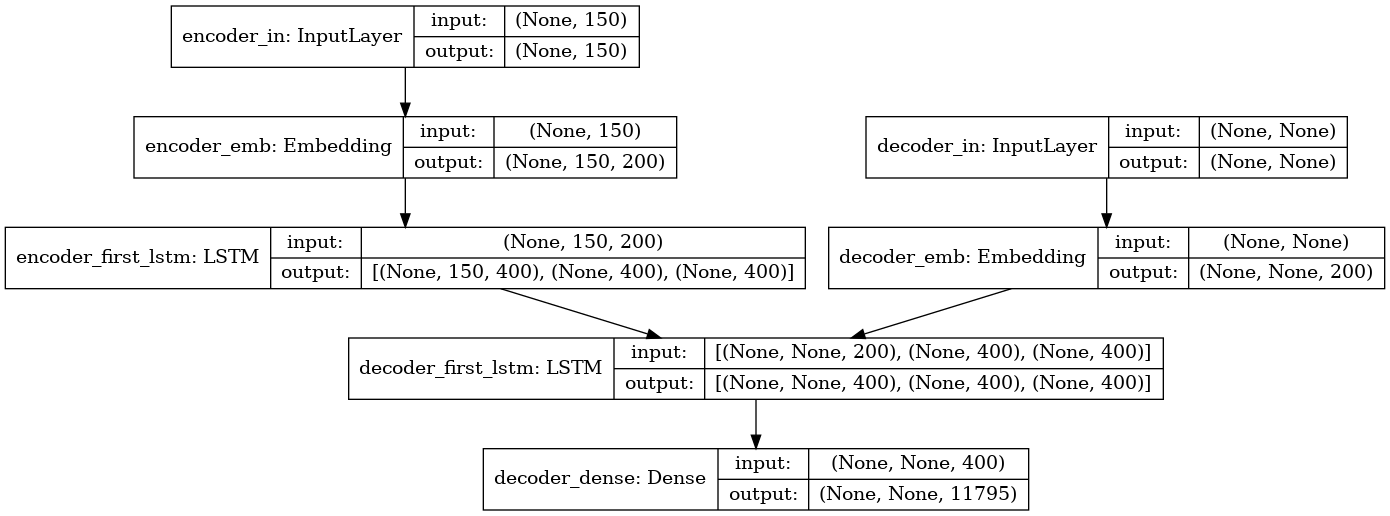

In [17]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [19]:
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=2)

mc = ModelCheckpoint('best_model.h5',
                    monitor = 'val_loss',
                    mode = 'min',
                    verbose = 1,
                    save_best_only = True)

In [20]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=20,
                  callbacks=[es, mc],
                  batch_size=256, 
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

/home/maksboruh/my_project_env/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 4005 samples, validate on 495 samples
Epoch 1/20
4005/4005 [==============================] - 64s 16ms/step - loss: 6.2493 - val_loss: 5.1744

Epoch 00001: val_loss improved from inf to 5.17443, saving model to best_model.h5
Epoch 2/20
4005/4005 [==============================] - 63s 16ms/step - loss: 5.2631 - val_loss: 5.0696

Epoch 00002: val_loss improved from 5.17443 to 5.06958, saving model to best_model.h5
Epoch 3/20
4005/4005 [==============================] - 63s 16ms/step - loss: 5.3012 - val_loss: 5.0752

Epoch 00003: val_loss did not improve from 5.06958
Epoch 4/20
4005/4005 [==============================] - 63s 16ms/step - loss: 4.9320 - val_loss: 4.7239

Epoch 00004: val_loss improved from 5.06958 to 4.72385, saving model to best_model.h5
Epoch 5/20
4005/4005 [==============================] - 63s 16ms/step - loss: 4.7726 - val_loss: 4.6652

Epoch 00005: val_loss improved from 4.72385 to 4.66519, saving model to best_model.h5
Epoch 6/20
4005/4005 [===============

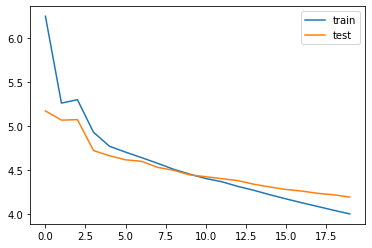

In [21]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [355]:
# def get_predicted_text(text, maxlen=max_len_text):
#     seqs = x_tokenizer.texts_to_sequences([text])
#     pad_seqs = pad_sequences(seqs, maxlen)
#     res = seq2seq_Model.predict(pad_seqs)
#     ty = x_tokenizer.sequences_to_texts(pad_seqs)
#     rr = ' '.join(ty)
#     return rr

In [22]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

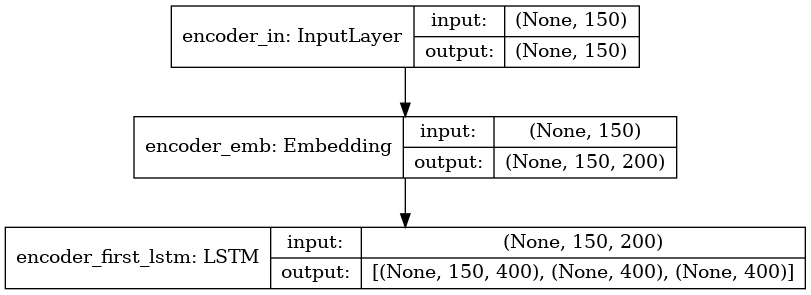

In [23]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

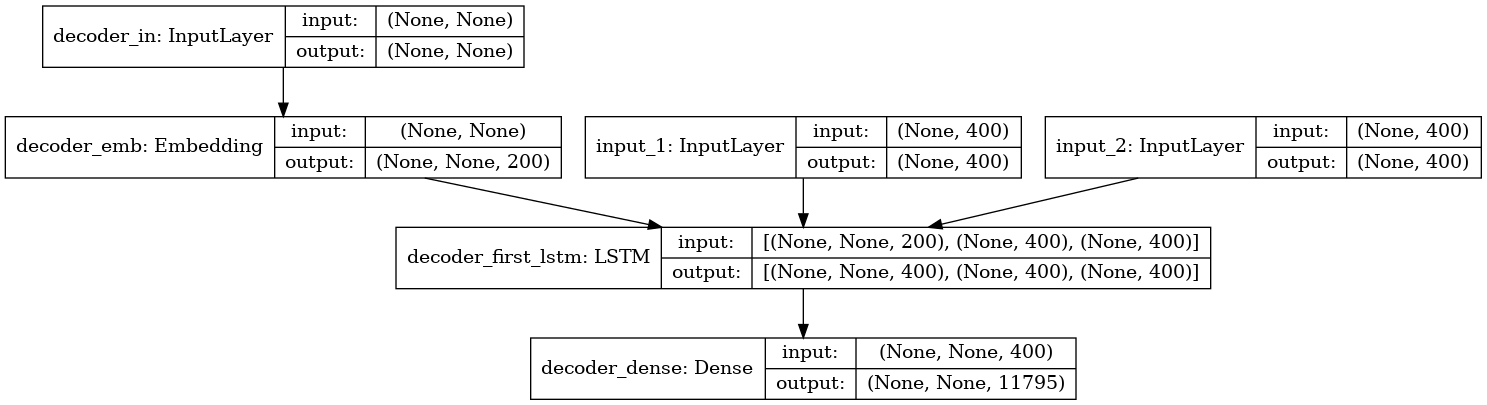

In [24]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
inputs = [decoder_inputs] + decoder_states_inputs,
outputs = [decoder_outputs2] + decoder_states )
plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # sampled_token_index = np.random.choice(len(output_tokens[0, -1, :]), p=output_tokens[0, -1, :])
        
        # sampled_token_index = beam_search_decoder(output_tokens[0, -1:], 1)
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token != 'eos'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [26]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '           
    return newString

def seq2text(input_seq):
    return x_tokenizer.sequences_to_texts([input_seq])[0]

In [27]:
def beam_search_decoder(data, k):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            candidate = [seq + [1], score - np.log(row)]
            all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
        sequences = sequences[0][0][0]
    return sequences

In [42]:
i=1
print("Review:", seq2text(x_val[i]))
print("\nOriginal summary:", seq2summary(y_val[i]))
print("\nPredicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
print("\n\n")

Review: vaccinate sphynx cat common infectious disease cat flu feline infectious enteritis feline leukemia rabies initial kitten vaccination require two dos effective give nine week age give three four week apartif doubt vaccinate phone local veterinary clinic advise protocol recommend work get cat booster injection year sphynx cat spayed neuter generally take place around five six month old female cat start get pregnant get cat fix also fit id chip permanent way identify cat preventative health care cat include parasite control deworming want discus flea prevention medicine vet also get cat dewormed every three month

Original summary: vaccinate your cat desex your cat control parasites and worms 

Predicted summary:  take a cage and a day of the day of the cage of the cage of the cage of the cage of the cage of the cage





In [362]:
# def beam_search_decoder(data, k):
#     sequences = [[list(), 0.0]]
#     # walk over each step in sequence
#     for row in data:
#         all_candidates = list()
#         # expand each current candidate
#         for i in range(len(sequences)):
#             seq, score = sequences[i]
#             for j in range(len(row)):
#                 candidate = [seq + [j], score - np.log(row[j])]
#                 all_candidates.append(candidate)
#         # order all candidates by score
        
#         ordered = sorted(all_candidates, key=lambda tup:tup[1])
#         # select k best
#         sequences = ordered[:k]
#     return sequences

In [363]:
# data = [[0.1, 0.2, 0.3, 0.4, 0.5]]
# data = np.array(data)
# # decode sequence
# result = beam_search_decoder(data, 3)

In [364]:
# result

In [365]:
# for seq in result:
# 	print(seq)

In [366]:
# e_out, e_h, e_c = encoder_model.predict(x_val[0].reshape(1, max_len_text))
# target_seq = np.zeros((1,1))

#     # Chose the 'start' word as the first word of the target sequence
# target_seq[0, 0] = target_word_index['sos']

# output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

In [367]:
# output_tokens[0][0]

In [368]:
# beam_search_decoder(output_tokens[0, -1:], 1)

In [369]:
# reverse_target_word_index

In [382]:
for i in range(1):
    print("Review:", seq2text(x_val[i]))
    print("\nOriginal summary:", seq2summary(y_val[i]))
    print("\nPredicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
    print("\n\n")

Review: forward rather backward bridle rather brow band position around horse ear always make sure reward horse good behavior encourage good accept bit bridle sugar also encourages play bit sugar cube really good treat hand bridling remember throatlatch hold bridle place operates extra precaution bridle come mean throatlatch need loose enough maintain slack even horse drop head make sure fit entire hand throatlatch horse even head bent towards neck brow band smooth correct position mean pinch horse ear head check bit sits evenly horse mouth two wrinkle either corner horse mouth few need shorten cheek strap make sure sits evenly horse head adjust cheek strap check rest headstall still even buckle curb chain chin strap isnt fix check length rein need long enough take contact horse mouth lead left cheek hold rein right hand six inch bit keep bight left hand always hold six inch bit keep slack rein left hand 

Original summary: with the treat keep pressure on the crown while it over their 

KeyError: 0

Keras doc
https://keras.io/guides/working_with_rnns/

In [96]:
# vocab = calc_vocab(train['text'])

In [97]:
# vocab

In [98]:
# vocab = int(vocab/2)

In [99]:
# y_vocab = calc_vocab(train['headline'])

In [100]:
# y_vocab

In [101]:
# y_vocab = int(y_vocab/2)

In [300]:
maxlen = 80
embed_dim = 120
batch_size = 32
latent_dim = 80
max_sum_len = 10

In [301]:
x_tokenizer = Tokenizer(num_words=6000)
x_tokenizer.fit_on_texts(train['text'])

x_train = x_tokenizer.texts_to_sequences(train['text'])
x_val = x_tokenizer.texts_to_sequences(val['text'])

x_train = pad_sequences(x_train, maxlen)
x_val = pad_sequences(x_val, maxlen)

In [302]:
x_vocab = len(x_tokenizer.word_index) + 1

In [303]:
encoder_inputs = Input(shape=(maxlen,))
emb_layer = Embedding(x_vocab, embed_dim)
x = emb_layer(encoder_inputs)
# encoder_lstm_1 = LSTM(200, activation='relu', return_sequences=True, dropout=0.1)(x)
# encoder_lstm_2 = LSTM(120, activation='sigmoid', return_sequences=True, dropout=0.2)(encoder_lstm_1)
encoder_lstm_3 = LSTM(latent_dim, activation='relu')(x)

In [304]:
decoded = RepeatVector(latent_dim)(encoder_lstm_3)

# decoder_inputs = Input(shape=(max_sum_len,)) 
# dec_emb_layer = Embedding(vocab, embed_dim, input_length = max_sum_len) 
# dec_emb = dec_emb_layer(decoder_inputs) 

# decoder_conc = concatenate([decoded, dec_emb])
decoder_lstm = LSTM(100, return_sequences=True) (decoded)
decoder_outputs = TimeDistributed(Dense(6000, activation='softmax'))(decoder_lstm)

In [305]:
seq2seq_Model = Model(encoder_inputs, decoder_outputs) 
seq2seq_Model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 80)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 80, 120)           2208480   
_________________________________________________________________
lstm_7 (LSTM)                (None, 80)                64320     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 80, 80)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 80, 100)           72400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 80, 6000)          606000    
Total params: 2,951,200
Trainable params: 2,951,200
Non-trainable params: 0
________________________________________________

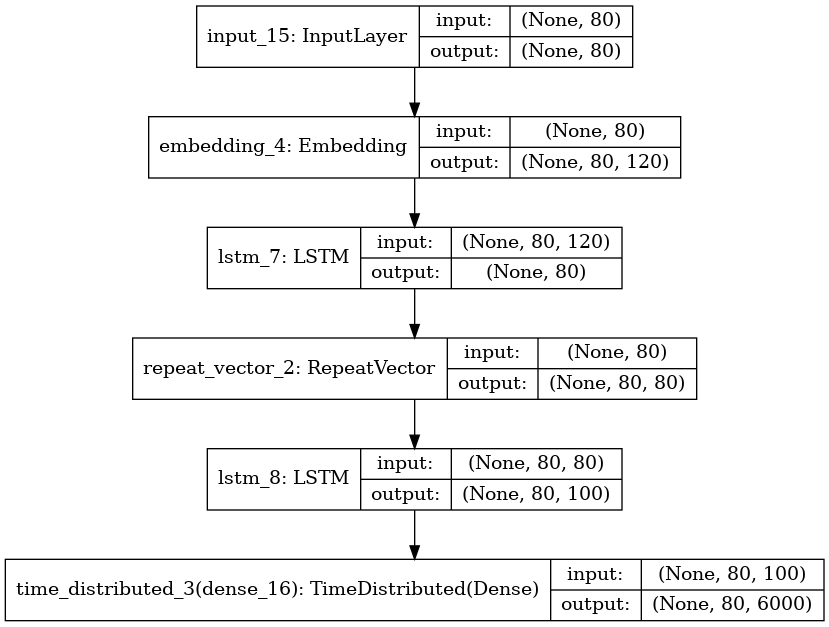

In [306]:
plot_model(seq2seq_Model, to_file='test.png', show_shapes=True, show_layer_names=True)

In [307]:
seq2seq_Model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1,
                   patience = 3)

mc = ModelCheckpoint('best_sum_model.h5',
                    monitor = 'val_loss',
                    mode = 'min',
                    verbose = 1,
                    save_best_only = True)

In [308]:
history = seq2seq_Model.fit(x_train, np.expand_dims(x_train, -1), 
                            batch_size=32, 
                            callbacks = [es, mc],
                            epochs=15,
                            validation_data = (x_val, np.expand_dims(x_val, -1)))

/home/maksboruh/my_project_env/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 1602 samples, validate on 198 samples
Epoch 1/15
1602/1602 [==============================] - 13s 8ms/step - loss: 8.5679 - val_loss: 8.4349

Epoch 00001: val_loss improved from inf to 8.43492, saving model to best_sum_model.h5
Epoch 2/15
1602/1602 [==============================] - 13s 8ms/step - loss: 7.9064 - val_loss: 7.5422

Epoch 00002: val_loss improved from 8.43492 to 7.54221, saving model to best_sum_model.h5
Epoch 3/15
1602/1602 [==============================] - 13s 8ms/step - loss: 7.4135 - val_loss: 7.3145

Epoch 00003: val_loss improved from 7.54221 to 7.31446, saving model to best_sum_model.h5
Epoch 4/15
1602/1602 [==============================] - 13s 8ms/step - loss: 7.2506 - val_loss: 7.2077

Epoch 00004: val_loss improved from 7.31446 to 7.20768, saving model to best_sum_model.h5
Epoch 5/15
1602/1602 [==============================] - 13s 8ms/step - loss: 7.1650 - val_loss: 7.1457

Epoch 00005: val_loss improved from 7.20768 to 7.14566, saving model to best_

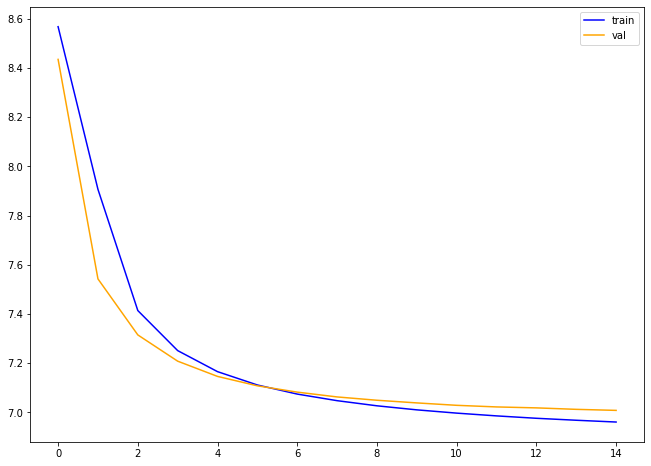

In [310]:
from matplotlib import pyplot
pyplot.figure(figsize = (11,8))
pyplot.plot(history.history['loss'], label = 'train', color = 'blue')
pyplot.plot(history.history['val_loss'], label = 'val', color = 'orange')

pyplot.legend()
pyplot.show()

In [313]:
def get_scores_rouge(text, prediction):
    rouge = Rouge()
    scores = rouge.get_scores(prediction, text)
    return scores

In [317]:
def get_predicted_text(text, maxlen=maxlen):
    seqs = x_tokenizer.texts_to_sequences([text])
    pad_seqs = pad_sequences(seqs, maxlen)
    res = seq2seq_Model.predict(pad_seqs)
    print(pad_seqs[0])
    ty = x_tokenizer.sequences_to_texts(pad_seqs)
    rr = ' '.join(ty)
    return rr

In [318]:
pred = get_predicted_text(list(test['text'])[0])

[ 454 1584  427  291 1133  260  217 1408  693 1392 4817  999   22 2271
    1 4817 1068 4557  285  570  750 1001   56  570 2643    1  525  155
  106  139  996   64  859 4557  285 1068 1964 2450  156  106  409  996
   64 1955 2309 4557  453   29  744  106  661  229 4817 1068  580  570
  202  106 1315  409 1955  404  859  580  659  106  140  101  580  659
   29  769 3883 4817  580  659  187 4585   32  580]


In [316]:
pred

'sense danger tend trust nature easily lead accident injury outdoors ragdolls safety keep indoor cat ragdolls prone breedspecific health condition early key treat condition effectively cat year old vet run blood work rule breedspecific health prone bladder kidney problem vet test blood work ragdoll diagnose breedspecific issue talk treatment vet due size ragdolls prone heart condition breed vet perform test ragdoll grow rule heart disease vet notice sign heart disease talk slow progression ragdolls heart disease usually thicken around heart'

In [114]:
# list(test['headline'])[0]

In [115]:
# pprint(get_scores_rouge(list(test['headline'])[0], pred))

In [116]:
# pred = get_predicted_text(list(train['text'])[0])

In [117]:
# pred

In [118]:
# list(train['headline'])[0]

In [119]:
# pprint(get_scores_rouge(list(train['headline'])[0], pred))

In [120]:
def rouge_min(texts, rouge, metric):
    min_s = np.inf
    for text in texts:
        score = get_scores_rouge(text, get_predicted_text(text))[0].get(rouge).get(metric)
        if score < min_s:
            min_s = score
    return min_s

In [121]:
# rouge_min(list(test['text']), 'rouge-l', 'p')

In [122]:
# rouge_min(list(test['text']), 'rouge-l', 'r')

In [123]:
# rouge_min(list(test['text']), 'rouge-l', 'f')